# **Install detectron and dependencies**

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 7.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44076 sha256=c4dab494e510104156cb846c72719279438dfba8f676c3c496f09c9213114caa
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 5.6MB/s 
     |████████████████████████████████| 2.2MB 12.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201213-cp36-none-any.whl size=40711 sha256=d873d61b3a48108bde2ccf30b11f2ec1b220500391d37c6ad5cf87915f0f0c07
  Stored in directory: /root/.cache/pip/wheels/20/eb/f9/b537cf42e3b4c57fe2a49aecad264c775df2d89e0ffbf5b17d
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10505 sha256=7a6a7ffb9695b658afc6948a425238efb31ba9cfd83a45b26dab276773c4d7ff
  Stored in directory: /root/.cache/pip/wheels/9e/01/e4/1b68f5a2a6b9450ea4246d91840a77e1169f7d4722d76bbc47
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.

# **Importing libraries**

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import os

In [3]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from time import time
import imutils

# **Helper functions**

In [4]:
def acc_cars(input, target):
  target = target.squeeze(1)
  return (input.argmax(dim=1)==target).float().mean()

In [5]:
def infer_imagewithcontours(img):
    tic = time()
    learn.model.eval()
    with torch.no_grad():
      mask,_,_ = learn.predict(img)
    toc = time()
    print('prediction time',toc-tic)
    # erode_kernel = np.ones((3,3))
    mask_copy = mask.data
    np_mask = np.asarray(mask_copy).reshape(448, 448)
    # np_mask = cv2.erode(np.uint8(np_mask), erode_kernel, 1)
    cnts = cv2.findContours(np.uint8(np_mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    image_copy  = img.resize(448).data
    image_copy= np.asarray(image_copy)
    out= np.transpose(image_copy, (1,2,0))
    # for c in cnts:
    #   out = cv2.drawContours(out, [c], -1, (0, 255, 0), 2)
    tic = time()
    out, diags = coordinate_bbox_generator(cnts, out)
    toc = time()
    # print("length od scrathces", scratches)
    print('bbox generating time',toc-tic)
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    alpha = 0.3
    # out = alpha * np_mask.reshape(448,448,1) + (1-alpha) * out.get()
    return out, diags

In [6]:
def infer_imagewithcontours_vanilla(img):
    tic = time()
    learn.model.eval()
    with torch.no_grad():
      mask,_,_ = learn.predict(img)
    toc = time()
    print('prediction time',toc-tic)
    # erode_kernel = np.ones((3,3))
    mask_copy = mask.data
    np_mask = np.asarray(mask_copy).reshape(448, 448)
    # np_mask = np.array(mask_copy)
    # print(np_mask.dtype)
    # np_mask = cv2.erode(np.uint8(np_mask), erode_kernel, 1)
    cnts = cv2.findContours(np.uint8(np_mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    image_copy  = img.data
    image_copy= np.asarray(image_copy)
    print("arrray",image_copy.shape)
    out= np.transpose(image_copy, (1,2,0))
    # for c in cnts:
    #   out = cv2.drawContours(out, [c], -1, (0, 255, 0), 2)
    tic = time()
    w, h = img.shape[2], img.shape[1]
    out, box = coordinate_bbox_generator(cnts, out)
    toc = time()
    # print("length od scrathces", scratches)
    print('bbox generating time',toc-tic)
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    alpha = 0.3
    # out = alpha * np_mask.reshape(448,448,1) + (1-alpha) * out.get()
    return out, box

In [7]:
def bbox_maker(x_coord, y_coord, img):
  #finding minimum and  maximum coords
  r = x_coord
  c = y_coord
  # print(img)
  c1 = (min(r)-2, min(c)-2)
  # print(c1)
  c2 = (max(r)+2, max(c)+2)
  # print(c2)
  out = cv2.rectangle(img, c1, c2, (255, 0, 0), 4)
  return out

In [8]:
def overlap_handler(l1, r1, l2, r2):
  l3 = (min(l1[0], l2[0]), min(l1[1], l2[1]))
  r3 = (max(r1[0], r2[0]), max(r1[1], r2[1]))
  return l3, r3

In [9]:
def doOverlap(l1, r1, l2, r2): 
    # If one rectangle is on doOverlap(l1, r1, l2, r2)left side of other 
    if(l1[0] > r2[0] or l2[0] > r1[0]): 
        return False
  
    # If one rectangle is above other   
    if(l1[1] > r2[1] or l2[1] > r1[1]): 
        return False
  
    return True

In [10]:
def coordinate_bbox_generator(cnt, img):
  filtered_box = []
  for box in cnt:
    x_coord, y_coord = [], []
    for item in box:
      # print(item)
      x_coord.append(item[0][0])
      y_coord.append(item[0][1])
      # print(x_coord)
    r = x_coord
    c = y_coord
    # print(img)
    c1 = (min(r), min(c))
    # print(c1)
    c2 = (max(r), max(c))
    # print(c2)
    if (c2[0]-c1[0]>3 and c2[1]-c1[1]>3):
      filtered_box.append([c1, c2])
      # img = cv2.rectangle(img, c1, c2, (0, 0, 255), 1)
  print(len(filtered_box))
  # print(filtered_box)
  for idx1 in range(len(filtered_box)):
    final_box = filtered_box[idx1]
    # print(idx1)
    for idx2 in range(len(filtered_box)):
      # print(idx1, idx2)
      item1, item2 = filtered_box[idx1], filtered_box[idx2]
      # print(*item1, *item2)
      if idx1==idx2:
        continue
      elif doOverlap(*item1, *item2):
        # print("Yippee!!")
        filtered_box[idx2] = overlap_handler(*item1, *item2)
      # print(len(filtered_box))
  filtered_box, diags = unique_box_finder(filtered_box)
  print(len(filtered_box))
  # print(filtered_box)
  # scratch_lengths = []
  for i,item in enumerate(filtered_box):
    img = cv2.UMat(img).get()
    diag = ((item[0][0]-item[1][0])**2 + (item[0][1]-item[1][1])**2)**0.5
    # scratch_lengths.append(diag)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(type(item[0]))
    p1, p2 = scale_box(item[0], item[1], img.shape[1], img.shape[0])
    upper_left, lower_right = tuple(p1), tuple(p2)
    # upper_left, lower_right = tuple(item[0]), tuple(item[1])#str(int(diag))
    img = cv2.putText(img, 'dent', org = upper_left, fontFace = cv2.FONT_HERSHEY_PLAIN, fontScale =  1, color = (0,1,0), thickness = 1)
    img = cv2.rectangle(img, upper_left, lower_right, (0,1,0), 1)
  return img, filtered_box

In [11]:
def scale_box(p1, p2, w, h):
  wf = w/448
  hf = h/448
  scale = np.asarray([wf, hf])
  new_p1 = p1 * scale
  new_p2 = p2 * scale
  return new_p1.astype(int), new_p2.astype(int)

In [12]:
def unique_box_finder(filtered_box):
  diag_box = []
  for item in filtered_box:
    diag = (item[0][0]-item[1][0])**2 + (item[0][1]-item[1][1])**2
    diag_box.append(diag)

  db_set = set(diag_box)
  # print(diag_box.index(list(db_set)))
  # print(list(db_set))
  idxs = map(diag_box.index, list(db_set))
  # print(list(idxs))
  idx_list = list(idxs)
  pures = np.array(filtered_box)[idx_list]# it returns the indexes we want to keep
  return pures, list(db_set)

# **Fastai Inference**

In [13]:
learn = load_learner('/content/drive/My Drive/models/','car_dent.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source at

In [14]:
import pdb

In [15]:
imgpath = '/content/car.jpg.gallery.jpg'

prediction time 0.4298825263977051
arrray (3, 312, 480)
3
3
bbox generating time 0.012872934341430664


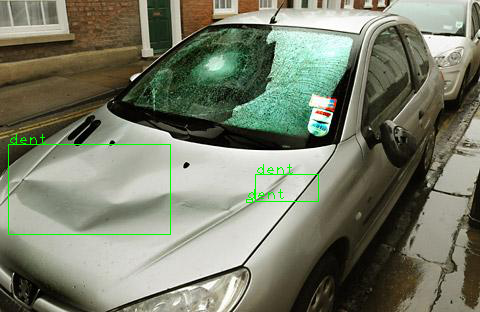

In [16]:
img = open_image(imgpath)
# img = open_image(path.ls()[24])
# print(np.asarray(img.data).shape)
# out = infer_imagewithcontours(img)
out, box=infer_imagewithcontours_vanilla(img)
# out = infer_image(img)
# print(type(out))
cv2_imshow(out*255)

In [17]:
box.shape

(3, 2, 2)

In [18]:
for item in box:
  print(item.shape)
  print(item)

(2, 2)
[[238 251]
 [297 290]]
(2, 2)
[[  8 208]
 [159 337]]
(2, 2)
[[230 286]
 [236 291]]


In [19]:
# g_box = box.reshape(2,2)

# **Detectron inference**

In [20]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/models/model_final.pth'
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5 # lower value decreases the number of reduntant boxes
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [21]:
thing_classes = ['frontbumper','bonnet','sidemirror','frontwindshield','frontfender','frontdoor','bootlid']

In [22]:
from detectron2.data.catalog import Metadata
meta_dict = {'name':'balloon_metadata', 'thing_classes':thing_classes}
balloon_metadata = Metadata(**meta_dict)

In [23]:
balloon_metadata

Metadata(name='balloon_metadata', thing_classes=['frontbumper', 'bonnet', 'sidemirror', 'frontwindshield', 'frontfender', 'frontdoor', 'bootlid'])

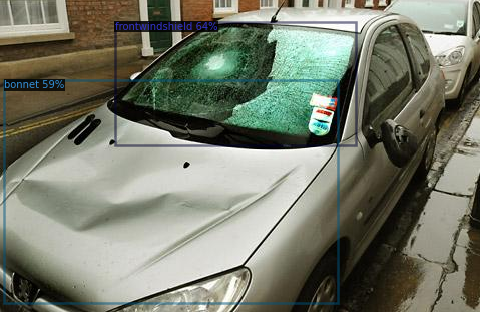

In [24]:
from detectron2.utils.visualizer import ColorMode
# im = cv2.imread("/content/98533765_Subscription_S.jpg")
im = cv2.imread(imgpath)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=balloon_metadata, 
                # metadata = MetadataCatalog.get('balloon_abc'),
                scale=1, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [25]:
part = outputs["instances"].pred_boxes.tensor.cpu()

In [26]:
label_idx = outputs["instances"].pred_classes.cpu()

In [ ]:
def calculate_damage():
  pass

In [28]:
damaged_partset  = set([])
flag = False
for part_box, idx in zip(part, label_idx):
  # print(part_box, idx )
  part_array = part_box.reshape(2,2)
  for g_box in box:
    l1,r1,l2,r2 = part_array[0], part_array[1], g_box[0], g_box[1]
    # print(doOverlap(l1,r1,l2,r2), idx)
    if doOverlap(l1,r1,l2,r2):
      # print(thing_classes[idx])
      flag = True
      damaged_partset.add(thing_classes[idx])
damaged_partset

{'bonnet'}

In [29]:
list(damaged_partset)

['bonnet']

In [30]:
def damage_part_finder():
  damaged_partset  = set([])
  flag = False
  for part_box, idx in zip(part, label_idx):
    # print(part_box, idx )
    part_array = part_box.reshape(2,2)
    for g_box in box:
      l1,r1,l2,r2 = part_array[0], part_array[1], g_box[0], g_box[1]
      # print(doOverlap(l1,r1,l2,r2), idx)
      if doOverlap(l1,r1,l2,r2):
        # print(thing_classes[idx])
        flag = True
        damaged_partset.add(thing_classes[idx])
  return list(damaged_partset)

In [36]:
part_array = np.asarray(part).reshape(g_box.shape)

In [37]:
box.shape

(1, 2, 2)

In [38]:
part_array

array([[ 166.43037,   55.94821],
       [1026.7809 ,  651.19476]], dtype=float32)

In [39]:
l1,r1,l2,r2 = part_array[0], part_array[1], g_box[0], g_box[1]
l1,r1,l2,r2

(array([166.43037,  55.94821], dtype=float32),
 array([1026.7809 ,  651.19476], dtype=float32),
 array([ 80, 180], dtype=int32),
 array([237, 301], dtype=int32))

In [40]:
doOverlap(l1,r1,l2,r2)

True

In [ ]:
def damage_scorer(l1, r1, l2, r2):
  l3 = (max(l1[0], l2[0]), max(l1[1], l2[1]))# finds top left coord of the intersection
  r3 = (min(r1[0], r2[0]), min(r1[1], r2[1]))# finds bottom right coord of the intersection
  l = r3[0] - l3[0]
  b = r3[1] - l3[1]
  inter_area = iter_len[0] * inter_len[1]
  # score = (l3 * r3) /
  return l3, r3, inter_len, inter_area

# **Combined Inference**

In [31]:
imgpath = '/content/car.jpg.gallery.jpg'
img = open_image(imgpath)
out, box=infer_imagewithcontours_vanilla(img)

from detectron2.utils.visualizer import ColorMode
im = cv2.imread(imgpath)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=balloon_metadata, 
                # metadata = MetadataCatalog.get('balloon_abc'),
                scale=1, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])
part = outputs["instances"].pred_boxes.tensor.cpu()
label_idx = outputs["instances"].pred_classes.cpu()
damage_partlist = damage_part_finder()
damage_partlist

prediction time 0.1376950740814209
arrray (3, 312, 480)
3
3
bbox generating time 0.0038504600524902344


['bonnet']

In [40]:
damage_partlist

['bonnet']

# Price estimator

In [35]:
import os
import json
prices_path = '/content/car part prices'
# make_list = os.listdir(prices_path)

print("Choose the index of make from the list")
for i,make in enumerate(sorted(os.listdir(prices_path))):
    print(i,". ",make)

make_list = sorted(os.listdir(prices_path))
idx = int(input("Choose the index of make from the list"))
filename = make_list[idx]

#pick up and the read the make into memory
filepath = os.path.join(prices_path, filename)
with open(filepath, "r") as file:
    make = json.load(file)

for i, item in enumerate(make['model_list']):
    print(i,". ", item["model_org_name"])

idx = int(input("Choose a model from the list"))
model = make['model_list'][idx]

print("Available trim for the this model")
for i, item in enumerate(model['trim_list']):
    print(i,". ", item["trim_org_name"])

idx = int(input("Choose a trim from the list"))
trim = model['trim_list'][idx]

damaged_parts = ['Wiper Blades','Bonnet']
try:
    for item in trim['data']['prices_list']:
        # print(item)
        for dpart in damage_partlist:
            if item['part_name'] == dpart:
                print("Part:", dpart)
                print("Minimum price:", item['price_min'])
                print("Maximum price:", item['price_max'])
except KeyError:
    print("No prices available for this trim type")

Choose the index of make from the list
0 .  Ashok_Leyland.json
1 .  Aston_Martin.json
2 .  Audi.json
3 .  BMW.json
4 .  Bajaj.json
5 .  Bentley.json
6 .  Bugatti.json
7 .  Caterham.json
8 .  Chevrolet.json
9 .  Chrysler.json
10 .  Citroen.json
11 .  DC.json
12 .  Daewoo.json
13 .  Datsun.json
14 .  Devel.json
15 .  Eicher_Polaris.json
16 .  Ferrari.json
17 .  Fiat.json
18 .  Force.json
19 .  Ford.json
20 .  GWM.json
21 .  HM.json
22 .  Haima.json
23 .  Honda.json
24 .  Hummer.json
25 .  Hyundai.json
26 .  ICML.json
27 .  Isuzu.json
28 .  Jaguar.json
29 .  Jeep.json
30 .  Kia.json
31 .  Lamborghini.json
32 .  Land_Rover.json
33 .  Lexus.json
34 .  MG.json
35 .  Mahindra.json
36 .  Mahindra_Renault.json
37 .  Mahindra_Ssangyong.json
38 .  Maruti_Suzuki.json
39 .  Maserati.json
40 .  Maybach.json
41 .  Mercedes-Benz.json
42 .  Mini.json
43 .  Mitsubishi.json
44 .  Nissan.json
45 .  Opel.json
46 .  Pagani.json
47 .  Porsche.json
48 .  Premier.json
49 .  Renault.json
50 .  Rolls-Royce.json


In [38]:
trim

{'body_type': 'hatchback',
 'data': {'code': 'success',
  'data': {'body_type': 'hatchback',
   'fuel_type': 'petrol',
   'vehicle_image': 'https://cdn1.acedms.com/uploads/category/maruti-suzuki/20171219093107000000-2201516130452271105.jpg'},
  'prices_list': [{'part_name': 'Wiper Blades',
    'price_max': '520',
    'price_min': '420'},
   {'part_name': 'Front Bumper', 'price_max': '1810', 'price_min': '1480'},
   {'part_name': 'Front Fender', 'price_max': '1580', 'price_min': '1290'},
   {'part_name': 'Bonnet', 'price_max': '3990', 'price_min': '3260'},
   {'part_name': 'Front Door', 'price_max': '5890', 'price_min': '4820'},
   {'part_name': 'Bootlid', 'price_max': '4840', 'price_min': '3960'},
   {'part_name': 'Front Windscreen Glass',
    'price_max': '3290',
    'price_min': '2690'},
   {'part_name': 'Side Mirrors', 'price_max': '1070', 'price_min': '880'},
   {'part_name': 'Front Strut', 'price_max': '1580', 'price_min': '1300'},
   {'part_name': 'Front Suspension Lower Arm',
  

In [46]:
thing_classes = ['frontbumper','bonnet','sidemirror','frontwindshield','frontfender','frontdoor','bootlid']
droom_classes = ['Front Bumper', 'Bonnet','Side Mirrors', 'Front Windscreen Glass', 'Front Fender', 'Front Door', 'Bootlid' ]

In [48]:
 t2d_dict = dict(zip(thing_classes, droom_classes)) 

In [43]:
damage_partlist

['bonnet']

In [49]:
damaged_parts = ['Wiper Blades','Bonnet']
try:
    for item in trim['data']['prices_list']:
        # print(item)
        for dpart in damage_partlist:
            if item['part_name'] ==  t2d_dict[dpart]:
                print("Part:", dpart)
                print("Minimum price:", item['price_min'])
                print("Maximum price:", item['price_max'])
except KeyError:
    print("No prices available for this trim type")

Part: bonnet
Minimum price: 3260
Maximum price: 3990


In [ ]:
def doOverlap(l1, r1, l2, r2): 
    # If one rectangle is on doOverlap(l1, r1, l2, r2)left side of other 
    if(l1[0] > r2[0] or l2[0] > r1[0]): 
        return False
  
    # If one rectangle is above other   
    if(l1[1] > r2[1] or l2[1] > r1[1]): 
        return False
  
    return True

In [32]:
# !unzip -q '/content/drive/MyDrive/car part prices.zip'